In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


## explore the data

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [3]:
print(f"Training entries: {len(train_data)}, labels: {len(train_labels)}")

Training entries: 25000, labels: 25000


In [4]:
print(train_data[0]) # words have been mapped to ids

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
print(len(train_data[0]), len(train_data[1])) # different length, need padding

218 189


## convert the integers back to words

In [6]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

word_index = {k:(v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = {v:k for k,v in word_index.items()}

def decode_review(text_ids):
    return ' '.join([reverse_word_index.get(i + 3, '?') for i in text_ids])

In [7]:
# test decode
decode_review(train_data[1])

"the thought solid thought senator do making to is spot nomination assumed while he of jack in where picked as getting on was did hands fact characters to always life thrillers not as me can't in at are br of sure your way of little it strongly random to view of love it so principles of guy it used producer of where it of here icon film of outside to don't all unique some like of direction it if out her imagination below keep of queen he diverse to makes this stretch and of solid it thought begins br senator and budget worthwhile though ok and awaiting for ever better were and diverse for budget look kicked any to of making it out and follows for effects show to show cast this family us scenes more it severe making senator to and finds tv tend to of emerged these thing wants but and an beckinsale cult as it is video do you david see scenery it in few those are of ship for with of wild to one is very work dark they don't do dvd with those them"

## Prepare the data

In [8]:
# paddings
train_data = keras.preprocessing.sequence.pad_sequences(sequences=train_data,
                                                       value=word_index['<PAD>'], 
                                                       padding='post',
                                                       truncating='post',
                                                       maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(sequences=test_data,
                                                      value=word_index['<PAD>'],
                                                      padding='post',
                                                      truncating='post',
                                                      maxlen=256)
print(len(train_data[0]), len(train_data[1]))

256 256


In [9]:
print(len(train_data[0]), len(train_data[1]))

256 256


In [10]:
print(train_data[1])

[   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26
    4  715    8  118 1634   14  394   20   13  119  954  189  102    5
  207  110 3103   21   14   69  188    8   30   23    7    4  249  126
   93    4  114    9 2300 1523    5  647    4  116    9   35 8163    4
  229    9  340 1322    4  118    9    4  130 4901   19    4 1002    5
   89   29  952   46   37    4  455    9   45   43   38 1543 1905  398
    4 1649   26 6853    5  163   11 3215    2    4 1153    9  194  775
    7 8255    2  349 2637  148  605    2 8003   15  123  125   68    2
 6853   15  349  165 4362   98    5    4  228    9   43    2 1157   15
  299  120    5  120  174   11  220  175  136   50    9 4373  228 8255
    5    2  656  245 2350    5    4 9837  131  152  491   18    2   32
 7464 1212   14    9    6  371   78   22  625   64 1382    9    8  168
  145   23    4 1690   15   16    4 1355    5   28    6   52  154  462
   33   89   78  285   16  145   95    0    0    0    0    0    0    0
    0 

## Build the model

In [11]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
# shape: (batch, sequence, embedding)，这里每个sample sequence长256
model.add(keras.layers.GlobalAveragePooling1D())
# shape: (batch, embeding)，average sequence这一维的值
# GlobalAveragePooling1D可以根据mask矩阵抉择要平均化的embddings
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


##  Create a validation set

In [13]:
val_num = 10000
x_val = train_data[:val_num]
partial_x_train = train_data[val_num:]

y_val = train_labels[:val_num]
partial_y_train = train_labels[val_num:]

## Train the model

In [14]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 0s 24us/sample - loss: 0.6922 - acc: 0.5192 - val_loss: 0.6908 - val_acc: 0.4983
Epoch 2/40
15000/15000 [==============================] - 0s 19us/sample - loss: 0.6878 - acc: 0.5896 - val_loss: 0.6849 - val_acc: 0.5950
Epoch 3/40
15000/15000 [==============================] - 0s 20us/sample - loss: 0.6778 - acc: 0.6693 - val_loss: 0.6720 - val_acc: 0.7106
Epoch 4/40
15000/15000 [==============================] - 0s 20us/sample - loss: 0.6583 - acc: 0.7175 - val_loss: 0.6488 - val_acc: 0.7517
Epoch 5/40
15000/15000 [==============================] - 0s 20us/sample - loss: 0.6281 - acc: 0.7661 - val_loss: 0.6173 - val_acc: 0.7709
Epoch 6/40
15000/15000 [==============================] - 0s 19us/sample - loss: 0.5892 - acc: 0.7979 - val_loss: 0.5800 - val_acc: 0.7849
Epoch 7/40
15000/15000 [==============================] - 0s 19us/sample - loss: 0.5445 - acc: 0.8183 - val_loss: 0.

## Evaluate the model

In [15]:
results = model.evaluate(test_data, test_labels, verbose=2)

25000/25000 - 0s - loss: 0.3647 - acc: 0.8575


In [16]:
# print loss and accuracy
print(results) 

[0.36469881927967074, 0.85748]


## Create a graph of accuracy and loss over time

model.fit() returns a History object that contains a dictionary with everything that happened during training:

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

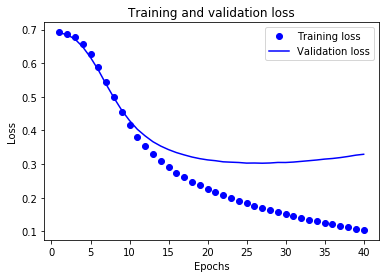

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for painting with "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# "b" is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

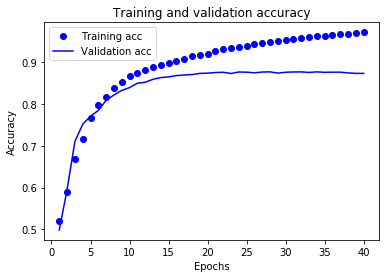

In [23]:
plt.clf() # clar figure

# "bo" is for painting with "blue dot"
plt.plot(epochs, acc, 'bo', label='Training acc')
# "b" is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()